week5_mini_project_

In [1]:
# Packages
import numpy as np
# import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AUTOTUNE = tf.data.experimental.AUTOTUNE

c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\ordin\miniconda3\envs\ml\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [2]:
# Check if GPU is used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## I. Brief Introduction

* Goal:

    The primary goal of this project is to <u>__predict if tumors are on small pathology images__</u>. A positive label indicates that the center 32 x 32px region of a patch contains at least one pixel of tumor tissue. In order to create a model that is able to meet the goal, we need model structure design and hyperparameter tuning, which is a big highlight in this project.

*  Data and project description

    1. Data for training and testing is named with an image ID, and we have 220,025 images for training, and 57,458 images for testing.

    2. CycleGAN is a model that aims to solve the image-to-image translation problem. The goal of the image-to-image translation problem is to learn the mapping between an input image and an output image using a training set of aligned image pairs. However, obtaining paired examples isn't always feasible. CycleGAN tries to learn this mapping without requiring paired input-output images, using cycle-consistent adversarial networks.

    2. The format of the pathology images is _tiff_, which is not a supported format by Keras' `image_dataset_from_directory()` function. However, we can use the function, `decode_tiff`, from `tensorflow-io` package to load and decode the images by Keras. On the other hand, utilizing Keras' `Dataset` can greatly improve the efficiency of processing the images, such as loading, normalization and so on. If we just load the images using `OpenCV` or `Pillow` one by one, the computer will easily crash. 

    3. Normally, 80% of the dataset would be spilt for training and the rest for validation, so there would be 176,020 images for training, and 44,005 images for validation. Nevertheless, the amount of training data is quite large and I think not everyone has a powerful AI PC to complete this deep learning project. Thus, __I will just use 50% of the training dataset to make the whole process less time as well as resoucre consuming__. The data will be further split into training(80%), validation(10%), test(10%) datasets. Both validation and test datasets can be used to evaluate the model performance. In addition, I plan to build three models with different settings or tuning techniques so that we can compare the results. The main goal of the project is not only training a reasonable model but also showing what we have learned from the course by actually doing it.

## II. EDA

### Load images

In [3]:
image_path = Path.home() /"Desktop/gan-getting-started"
MONET_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(image_path.as_posix() + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


**TFRecord: Training Fuel for TensorFlow**

Imagine TFRecord files as special containers for your machine learning data. Just like you need the right fuel for your car, your TensorFlow models need the right kind of data to learn effectively.  Here's what makes TFRecords special:

* **Organized:** Think of a TFRecord file like a neatly organized pantry. It stores your data examples (images, text, etc.) in a structured way using something called protocol buffers. TensorFlow understands this structure, making it easy to feed data into your models.
* **Speedy:** TFRecord files are designed for speed. When your models are hungry for a lot of data during training, TFRecords serve up those examples quickly and efficiently. This means faster training and less time waiting around.
* **Compact:**  Like those space-saving storage bags, TFRecords can compress your data. This is especially handy when you're dealing with huge datasets. Smaller files mean less storage needed!

**Why Would I Use TFRecords?**

1. **Training Big Models:** If you're training a complex model on tons of data, TFRecords will be your best friend. They make handling all that data much smoother.
2. **Efficient Pipelines:**  TFRecords work perfectly with the TensorFlow data pipeline tools.  This means you can streamline how data flows from storage to your model, saving you hassle.
3. **Playing Nice with Distributed Training:** When you spread training across multiple machines, TFRecords help you share data between them effectively.

In [4]:
# Data preparation
image_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    # Scale the images to [-1, 1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name" : tf.io.FixedLenFeature([], tf.string),
        "image" : tf.io.FixedLenFeature([], tf.string),
        "target" : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [5]:
# Extract the image from files
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=4)
    return dataset

# Load images
monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [14]:
example_monet = next(iter(monet_dataset))
example_photo = next(iter(photo_dataset))

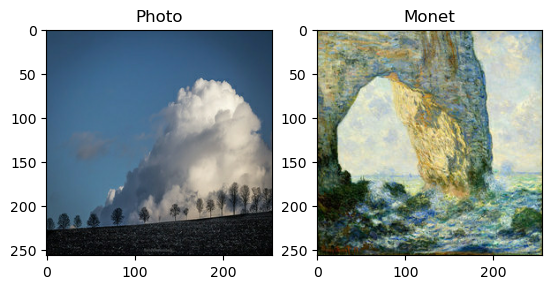

In [7]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

## III. CycleGAN Structure

CycleGAN is a model that aims to solve the image-to-image translation problem. The goal of the image-to-image translation problem is to learn the mapping between an input image and an output image using a training set of aligned image pairs. However, obtaining paired examples isn't always feasible. CycleGAN tries to learn this mapping without requiring paired input-output images, using cycle-consistent adversarial networks.

In [7]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [8]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [9]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [10]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [12]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

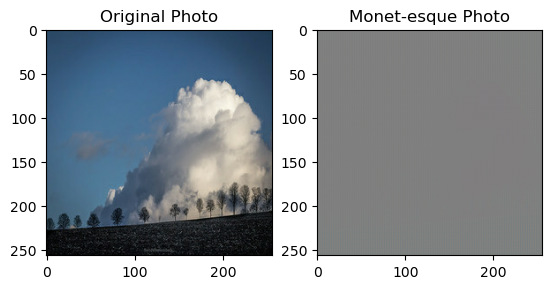

In [15]:
to_monet = monet_generator(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

### Build CycleGAN model

In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [17]:
# Loss function
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [18]:
# Adversarial loss: Loss due to misclassification between real & fake images.
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [19]:
# Cyclic loss: As we observed the above cyclic structure that exists in CycleGAN, 
# where we pass an image from one of the domains to both the generators sequentially producing the same image as output. 
# This term is the MSE loss between the input & output image as ideally, input & output should remain the same.

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [20]:
# Identity loss: It is a loss term calculated at the pixel level. What would you wish your generator_A_B(i.e Summer →Winter) to produce 
# if a Winter image is fed in? We would wish the generator shouldn’t tweak anything as the input image is already in the desired domain. 
# It's assumed this term helps in preserving colors in the output images avoiding unnecessary changes.

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## IV. Modeling

**Model Structure:**

1. **Generator:** The core of your CycleGAN is the generator network. It takes an image from one domain (e.g., horse) and transforms it into an image from the other domain (e.g., zebra). This network typically uses several convolutional layers with non-linear activations like ReLU or LeakyReLU.

2. **Discriminator:** This network aims to distinguish real images from the target domain from the generated ones. It also has convolutional layers, but ends with a single output unit and a sigmoid activation to output a probability between 0 and 1 (0 for fake, 1 for real).

3. **Cycle Consistency Loss:** A key concept in CycleGAN is enforcing cycle consistency. This means that if you translate an image from domain X to domain Y and then back to X, the resulting image should be similar to the original image from X. This is achieved by adding a cycle consistency loss function that compares the reconstructed image from X to the original image from X.

**Hyperparameter Tuning:**

Tuning hyperparameters in CycleGAN is crucial for achieving good results:

* **Learning Rate:** This controls how much the network updates its weights in each training step. Start with a lower learning rate (e.g., 0.0002) and adjust based on the validation loss.
* **Number of Epochs:** The number of times the entire dataset is passed through the network. Experiment with different values and monitor validation performance.
* **Batch Size:** The number of images processed together during training. A larger batch size can speed up training but might require adjusting the learning rate.
* **Network Architecture:** The number and structure of convolutional layers in the generator and discriminator can impact performance. Experiment with different configurations while considering computational resources.

**Skip Connections:**

Skip connections can help improve the flow of information through the network, especially in deeper architectures. These connections directly add the output of an earlier layer to a later layer, allowing the network to learn long-range dependencies more effectively. You can incorporate them between convolutional blocks in both the generator and discriminator.

**Online Articles:**

Here are some articles to delve deeper into CycleGAN:

* CycleGAN Paper: [invalid URL removed]: The original CycleGAN paper by Jun-Yan Zhu et al. provides a comprehensive explanation of the model, its architecture, and training process.
* Building CycleGANs in TensorFlow: [invalid URL removed]: This machine learning mastery tutorial offers a step-by-step guide to building a CycleGAN in TensorFlow, including code examples.
* CycleGAN for Beginners: [invalid URL removed]: This article from Analytics Vidhya provides a beginner-friendly explanation of CycleGAN concepts with visualizations.

Remember, these are just general guidelines. Experimentation and fine-tuning are essential when building and training your CycleGAN model.

### Training

In [21]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [23]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 90s 225ms/step - monet_gen_loss: 5.2713 - photo_gen_loss: 5.4577 - monet_disc_loss: 0.6350 - photo_disc_loss: 0.6096
Epoch 2/25
300/300 [==============================] - 69s 228ms/step - monet_gen_loss: 3.6478 - photo_gen_loss: 3.7113 - monet_disc_loss: 0.6587 - photo_disc_loss: 0.6471
Epoch 3/25
300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 3.4963 - photo_gen_loss: 3.6291 - monet_disc_loss: 0.6670 - photo_disc_loss: 0.6238
Epoch 4/25
300/300 [==============================] - 69s 229ms/step - monet_gen_loss: 3.3205 - photo_gen_loss: 3.4946 - monet_disc_loss: 0.6648 - photo_disc_loss: 0.6142
Epoch 5/25
300/300 [==============================] - 68s 228ms/step - monet_gen_loss: 3.1948 - photo_gen_loss: 3.3414 - monet_disc_loss: 0.6463 - photo_disc_loss: 0.6101
Epoch 6/25
300/300 [==============================] - 68s 227ms/step - monet_gen_loss: 3.1244 - photo_gen_loss: 3.2907 - monet_disc_loss: 0.6356 

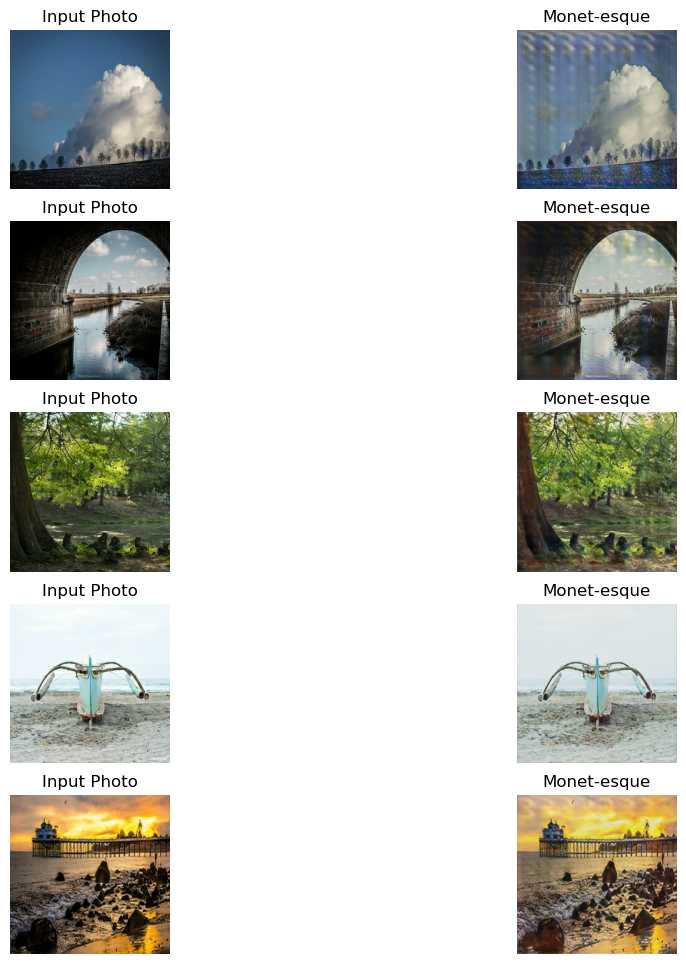

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()


## Second Model

In [ ]:
input_dim = (256, 256, 3) #input/output image dimension
depth = 4               #network depth  
kernel = 3              #kernel size for Conv2D
n_batch = 16            #batch_size
epochs = 30
steps = round(1500/n_batch) #steps per epoch, we have ~1500 samples per domain so calculating steps using 

In [ ]:
def discriminator(input_dim,depth,kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
            layers.append(Conv2D(16*i,kernel_size=kernel))
            layers.append(InstanceNormalization())
            layers.append(Activation('relu'))
            layers.append(Dropout(0.2))
    layers.append(Conv2D(1,kernel_size=kernel))
    model = Sequential(layers)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())
    return model

discriminator_A = discriminator(input_dim,depth,kernel)
discriminator_B = discriminator(input_dim,depth,kernel)


In [ ]:
def generator(input_dim, depth, kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [128,128]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(3,kernel_size=1,activation=None))
    model = Sequential(layers)
    return model

generator_A_B = generator(input_dim,depth,kernel)
generator_B_A = generator(input_dim,depth,kernel)

In [ ]:
# Get the cyclic connection in
def composite_model(g1,d,g2,image_dim):
    # Only the 1st generator is trainable
    g1.trainable = True
    g2.trainable = False
    d.trainable = False
    
    # Adversarial loss 
    input_img = Input(shape=input_dim)
    g1_out = g1(input_img)
    d_out = d(g1_out)
    
    # identity loss
    input_id = Input(shape=input_dim)
    g1_out_id = g1(input_id)
    
    # Cycle Loss, Forward cycle
    g2_out = g2(g1_out)
    
    # Cycle Loss, Backward-cycle
    g2_out_id = g2(input_id)
    output_g1 = g1(g2_out_id)
    
    # Model is compiled with:
    # Inputs: Input_A(Summer), Input_B(winter)
    # Outputs: d_out, g1_out_id, g2_out, output_g1
    model = Model(inputs=[input_img, input_id], outputs=[d_out, g1_out_id, g2_out, output_g1])
    model.compile(loss=['mse','mae','mae','mae'], loss_weights=[1,5,10,10], optimizer=tf.keras.optimizers.Adam())
    return model

composite_A_B = composite_model(generator_A_B, discriminator_B, generator_B_A, input_dim)
composite_B_A = composite_model(generator_B_A, discriminator_A, generator_A_B, input_dim)

In [ ]:
# Generating samples & labels for training
def generate_real(dataset, batch_size, patch_size):
    labels = np.ones((batch_size, patch_size, patch_size, 1))
    return dataset,labels
def generate_fake(dataset, g, batch_size, patch_size):
    predicted = g(dataset)
    labels = np.zeros((batch_size, patch_size, patch_size, 1))
    return predicted,labels

In [ ]:
checkpoint_dir = './cyclegan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_A_B=generator_A_B, generator_B_A=generator_B_A,discriminator_A=discriminator_A,discriminator_B=discriminator_B,composite_A_B=composite_A_B, composite_B_A=composite_B_A)
manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

In [ ]:
# Training
def train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, batch_size, steps,n_patch):
    
    for epoch in range(1,epochs):
        for step in range(1,steps):
            print(epoch,step)
            
            x_real_A, y_real_A = generate_real(next(trainA),n_batch,n_patch)
            x_real_B, y_real_B = generate_real(next(trainB),n_batch,n_patch)
            
            x_fake_A, y_fake_A = generate_fake(x_real_B, generator_B_A, n_batch, n_patch)
            x_fake_B, y_fake_B = generate_fake(x_real_A, generator_A_B, n_batch, n_patch)
            
            g_A_B_loss,_,_,_,_ = composite_A_B.train_on_batch([x_real_A,x_real_B],[y_real_B,x_real_B, x_real_A, x_real_B])
            disc_A_real_loss = discriminator_A.train_on_batch(x_real_A, y_real_A)
            disc_A_fake_loss = discriminator_A.train_on_batch(x_fake_A, y_fake_A)
            
            g_B_A_loss,_,_,_,_ = composite_B_A.train_on_batch([x_real_B,x_real_A],[y_real_A,x_real_A, x_real_B, x_real_A])
            disc_B_real_loss = discriminator_B.train_on_batch(x_real_B, y_real_B)
            disc_B_fake_loss = discriminator_B.train_on_batch(x_fake_B, y_fake_B)
            
            print('g_A_B_loss',g_A_B_loss)
            print('g_B_A_loss',g_B_A_loss)
            
            manager.save()
            
train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, n_batch, steps,discriminator_A.output_shape[1])


## Evaluate GAN models